In [2]:
from ecog2vec.data_generator import NeuralDataGenerator

In [3]:
efc401 = NeuralDataGenerator('/NWB/EFC401', 'EFC401')
efc401.bad_electrodes = [1,2,63,64,65,127,143,193,194,195,196,235,239,243,252,254,255,256]
efc401.bad_electrodes = [x - 1 for x in efc401.bad_electrodes]
efc401.good_electrodes = [x for x in efc401.good_electrodes if x not in efc401.bad_electrodes]
# efc400 = NeuralDataGenerator('/NWB/EFC400', 'EFC400')

In [4]:
import os
# Save clipped data for training,
# save unclipped data to extract features from,
# save entire recording as chunks for training,
# save entire reocording to extract features from
parent_dir = '/home/bayuan/Documents/fall23/ecog2vec/wav2vec_inputs'

chopped_sentence_dir = '/home/bayuan/Documents/fall23/ecog2vec/wav2vec_inputs/chopped_sentence'
sentence_dir = '/home/bayuan/Documents/fall23/ecog2vec/wav2vec_inputs/sentence'
chopped_recording_dir = '/home/bayuan/Documents/fall23/ecog2vec/wav2vec_inputs/chopped_recording'
full_recording_dir = '/home/bayuan/Documents/fall23/ecog2vec/wav2vec_inputs/full_recording'

for directory in [parent_dir, chopped_sentence_dir, sentence_dir, chopped_recording_dir, full_recording_dir]:
    os.makedirs(directory, exist_ok=True)
    print(f"Directory created or already exists: {directory}")

chunk_length = 200000

block_list = []

# 'write_raw_data', but really it's filtered to the high
# gamma range and the analytic amplitude is calculated
efc401.write_raw_data(
    chopped_sentence_dir=chopped_sentence_dir,
    sentence_dir=sentence_dir,
    # full_recording_dir=full_recording_dir,
    # chopped_recording_dir=chopped_recording_dir,
    chunk_length=chunk_length)

Directory created or already exists: /home/bayuan/Documents/fall23/ecog2vec/wav2vec_inputs
Directory created or already exists: /home/bayuan/Documents/fall23/ecog2vec/wav2vec_inputs/chopped_sentence
Directory created or already exists: /home/bayuan/Documents/fall23/ecog2vec/wav2vec_inputs/sentence
Directory created or already exists: /home/bayuan/Documents/fall23/ecog2vec/wav2vec_inputs/chopped_recording
Directory created or already exists: /home/bayuan/Documents/fall23/ecog2vec/wav2vec_inputs/full_recording


/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached na

Split into test/valid and train.

Strides should downsample by ~30x; `wav2vec` takes 16kHz inputs and our raw data is at 3kHz

In [5]:
# Borrowed from facebookresearch/fairseq with minor modifications

!python3 /home/bayuan/Documents/fall23/fairseq/examples/wav2vec/wav2vec_manifest.py \
    /home/bayuan/Documents/fall23/ecog2vec/wav2vec_inputs/chopped_sentence \
  --dest /home/bayuan/Documents/fall23/ecog2vec/manifest \
  --ext wav \
  --valid-percent 0.05 \
  --seed 42

In [5]:
# Borrowed from facebookresearch/fairseq with minor modifications
# , (512, 4, 3), (512, 4, 2), (512, 1, 1)

!python3 -c 'import argparse; print(argparse.__file__)'
!python3 /home/bayuan/Documents/fall23/fairseq/train.py \
    /home/bayuan/Documents/fall23/ecog2vec/manifest \
  --save-dir /home/bayuan/Documents/fall23/ecog2vec/model \
  --num-workers 6 --fp16 --max-update 400000 --save-interval 1 --infonce --no-epoch-checkpoints \
  --arch wav2vec --task audio_pretraining --min-lr 1e-06 --stop-min-lr 1e-09 --optimizer adam --lr 0.0001 --lr-scheduler cosine \
  --conv-feature-layers "[(512, 8, 30)]" \
  --conv-aggregator-layers "[(512, 2, 1), (512, 3, 1), (512, 4, 1)]" \
  --skip-connections-agg --residual-scale 0.5 --log-compression --warmup-updates 500 --warmup-init-lr 1e-07 --num-negatives 10 \
  --max-sample-size 1500000 --skip-invalid-size-inputs-valid-test  --batch-size 10 --max-tokens 1500000000 \
  --tensorboard-logdir /home/bayuan/Documents/fall23/ecog2vec/runs --prediction-steps 12 --criterion wav2vec

/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/argparse.py
2023-12-12 19:39:51.854491: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 19:39:51.854530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 19:39:51.855719: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-12 19:39:51.860681: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compil

Extract $c$ embeddings.

extract sentence features


In [1]:
# Borrowed from facebookresearch/fairseq with minor modifications

import torch
import fairseq
# from scipy.io import wavfile
import os
import soundfile as sf
import numpy as np

cp_path = '/home/bayuan/Documents/fall23/ecog2vec/model/checkpoint_best.pt'#'/path/to/wav2vec.pt'
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp_path])
model = model[0]
model.eval()

dir_path = '/home/bayuan/Documents/fall23/ecog2vec/wav2vec_inputs/sentence'
feature_dir = '/home/bayuan/Documents/fall23/ecog2vec/wav2vec_outputs/latent_sentence'

for directory in [feature_dir]:
    os.makedirs(directory, exist_ok=True)
    print(f"Directory created or already exists: {directory}")

for file in os.listdir(dir_path):

    wav_path = str(os.path.join(dir_path, file))

    wav_input_16khz, sr = sf.read(wav_path, dtype='float64')
    # 
    wav_input_16khz = wav_input_16khz.T
    wav_input_16khz = wav_input_16khz.reshape(1, 238, -1)#wav_input_16khz[np.newaxis, :, :] # change to 256; 480

    wav_input_16khz = torch.from_numpy(wav_input_16khz).to(torch.float)
    # print(wav_input_16khz.shape)

    # print(sr, wav_input_16khz.shape)
    z = model.feature_extractor(wav_input_16khz)
    c = model.feature_aggregator(z)
    
    torch.save(c, f"/home/bayuan/Documents/fall23/ecog2vec/wav2vec_outputs/latent_sentence/{file}.pt")

2023-12-07 20:01:27.922868: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 20:01:27.922904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 20:01:27.924055: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 20:01:27.929192: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 20:01:28.484365: W tensorflow/compiler/tf2

Directory created or already exists: /home/bayuan/Documents/fall23/ecog2vec/wav2vec_outputs/latent_sentence


extract entire recording features

In [6]:
# Borrowed from facebookresearch/fairseq with minor modifications

import torch
import fairseq
# from scipy.io import wavfile
import os
import soundfile as sf
import numpy as np

cp_path = '/home/bayuan/Documents/fall23/ecog2vec/model/checkpoint_best.pt'#'/path/to/wav2vec.pt'
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp_path])
model = model[0]
model.eval()

dir_path = '/home/bayuan/Documents/fall23/ecog2vec/wav2vec_inputs/full_recording'

for file in os.listdir(dir_path):

    wav_path = str(os.path.join(dir_path, file))

    wav_input_16khz, sr = sf.read(wav_path)
    print(type(wav_input_16khz))
    # 
    wav_input_16khz = wav_input_16khz.T
    wav_input_16khz = wav_input_16khz.reshape(1, 238, -1)#wav_input_16khz[np.newaxis, :, :] # change to 256; 480

    wav_input_16khz = torch.from_numpy(wav_input_16khz).to(torch.float)
    # print(wav_input_16khz.shape)

    # print(sr, wav_input_16khz.shape)
    z = model.feature_extractor(wav_input_16khz)
    c = model.feature_aggregator(z)
    
    torch.save(c, f"/home/bayuan/Documents/fall23/ecog2vec/wav2vec_outputs/full_recording/{file}.pt")

2023-12-13 10:18:06.869683: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 10:18:06.869719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 10:18:06.870924: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 10:18:06.876303: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-13 10:18:07.409568: W tensorflow/compiler/tf2

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Let's look at the data


In [8]:
import torch

# cc = torch.load('/home/bayuan/Documents/fall23/ecog2vec/wav2vec_outputs/latent_representations/EFC400/EFC400_B3.nwb_0.wav.pt')
c = torch.load('/home/bayuan/Documents/fall23/ecog2vec/wav2vec_outputs/latent_sentence/EFC401_B4.nwb_0.wav.pt')
cc = c #.detach().numpy()[0]

print(cc.shape)
# print(cc[6])

(512, 394)


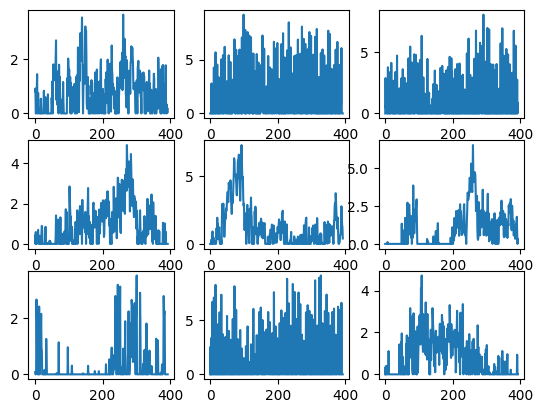

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,3)

# print(len(cc[0]))
ax[0,0].plot(cc[0])
ax[0,1].plot(cc[1])
ax[0,2].plot(cc[2])
ax[1,0].plot(cc[3])
ax[1,1].plot(cc[4])
ax[1,2].plot(cc[5])
ax[2,0].plot(cc[6])
ax[2,1].plot(cc[7])
ax[2,2].plot(cc[8])

# plt.plot(cc[1])


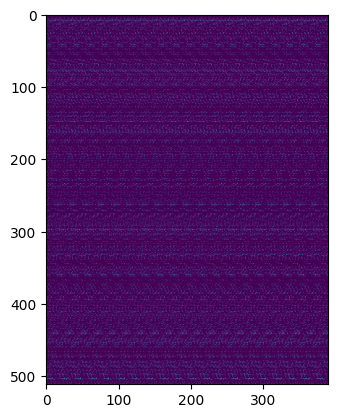

In [18]:
# c = c.detach().numpy()
plt.imshow(c[:,:])

Other experiments...

Train wav2vec -> extract embedding from ENTIRE recording -> split into sentences

In [7]:
import torch
import os
from pynwb import NWBHDF5IO
import numpy as np
import soundfile as sf
import pandas as pd

file_list = []
entire_recording_dir = '/home/bayuan/Documents/fall23/ecog2vec/wav2vec_outputs/full_recording'
patient = 'EFC401'
nwb_file_dir = '/NWB/EFC401'
nwb_file_prefix = f'{patient}_B'
nwb_file_suffix = f'.wav.pt'

saved_latent_sentences_dir = '/home/bayuan/Documents/fall23/ecog2vec/wav2vec_outputs/latent_sentence'

for file in os.listdir(entire_recording_dir):
    c_filepath = os.path.join(entire_recording_dir, file)
   
    c = torch.load(c_filepath).detach().numpy().reshape(512, -1)
    nwb_file = file.rstrip(nwb_file_suffix)
    
    nwb_path = os.path.join(nwb_file_dir, nwb_file)
    io = NWBHDF5IO(nwb_path, load_namespaces=True, mode='r')
    nwbfile = io.read()
    
    sr = 101.7
    
    starts = list(nwbfile.trials[:]['start_time'] * sr)
    stops = list(nwbfile.trials[:]['stop_time'] * sr)
    starts = [int(start) for start in starts]
    stops = [int(stop) for stop in stops]
    
    i = 0
    for start, stop in zip(starts, stops):
        speaking_segment = c[:,start:stop]
        torch.save(speaking_segment, f'{saved_latent_sentences_dir}/{nwb_file}_{i}.wav.pt')
        i = i + 1
    
# file_list

/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached na